In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
get_data_path = lambda folders, fname: os.path.normpath(os.environ['DRIVE_PATH'] + '/' + '/'.join(folders) + '/' + fname)
file_path = get_data_path(['SL PRED', 'NEW'], 'data_SL_pred.csv')

#figure_path_a = get_data_path(['SL PRED', 'Fig 1'], 'gene_box_plots_v3.png')
#figure_path_b = get_data_path(['SL PRED', 'Fig 1'], 'indv_gene_feature_aucs_v3.png') 

In [4]:
# load dataframe
df = pd.read_csv(file_path)
df.head()

,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,mean_age,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702
1,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702
2,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702
3,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000681,A549_LUNG,0.977988,0.379455,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702
4,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000756,GI1_CENTRAL_NERVOUS_SYSTEM,0.999586,-0.077118,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702


In [ ]:
features = ['rMaxExp_A1A2', 'rMinExp_A1A2',
            'max_ranked_A1A2', 'min_ranked_A1A2',
             'max_cn', 'min_cn', 'Protein_Altering', 'Damaging', 
             'max_seq_id', 'min_seq_id',
             'prediction_score', 
             'ranked_Essentiality_weighted_PPI', 'Expression_weighted_PPI',
             'smallest_GO_ranked_ess', 'smallest_GO_CC_ranked_ess',
            'smallest_gene_expression', 'smallest_GO_CC_expression'
            ]

target = 'SL_new'

In [6]:
#remove NA values before training the model
#df_clean = df.dropna(axis=0, how='any', subset=features + [target]).reset_index(drop=True) 

#summary of the training dataset after removing NA values
print(f"Number of SL pairs: {df[df[target] == True].shape[0]} / {df.shape[0]}")
print(f"Number of non-SL pairs: {df[df[target] == False].shape[0]} / {df.shape[0]}")
print(f'Number of unique gene pairs: {df.genepair.nunique()}')
print(f'Number of unique cell lines: {df.cell_line.nunique()}')
df[:3]

Number of SL pairs: 958 / 41244
Number of non-SL pairs: 40286 / 41244
Number of unique gene pairs: 4170
Number of unique cell lines: 10


,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,mean_age,either_in_complex,mean_complex_essentiality,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr
0,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702
1,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702
2,A3GALT2_ABO,A3GALT2,ABO,127550,28,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,226.1,False,0.0,0.0,False,3.0,0.0,0.114847,0.258739,11.702


In [9]:
df.columns

Index(['genepair', 'A1', 'A2', 'A1_entrez', 'A2_entrez', 'DepMap_ID',
       'cell_line', 'Gemini_FDR', 'raw_LFC', 'SL', 'org_A1', 'org_A2',
       'A1_copy_number_data', 'A1_expression_data', 'A1_gene_effect_data',
       'A1_zexpression_data', 'A1_zgene_effect_data', 'A2_copy_number_data',
       'A2_expression_data', 'A2_gene_effect_data', 'A2_zexpression_data',
       'A2_zgene_effect_data', 'A1_Deleterious', 'A1_mut', 'A2_Deleterious',
       'A2_mut', 'zMaxExp_A1A2', 'zMinExp_A1A2', 'rMaxExp_A1A2',
       'rMinExp_A1A2', 'max_cn', 'min_cn', 'zMaxESS_A1A2', 'zMinESS_A1A2',
       'rMaxESS_A1A2', 'rMinESS_A1A2', 'Protein_Altering', 'Damaging',
       'z_ranked_BioGRID_MW', 'ranked_Essentiality_weighted_PPI',
       'ranked_BioGRID_MV', 'z_ranked_BioGRID_ALL', 'Expression_weighted_PPI',
       'ranked_BioGRID_ALL', 'smallest_GO_CC_expression',
       'smallest_GO_ranked_ess', 'smallest_gene_expression',
       'smallest_GO_CC_ranked_ess', 'min_seq_id', 'max_seq_id', 'A1_rank',
     

### Individual Feature Analysis: Predictive Power of Genomic Features
### Bar plot

Calculate the predictive power of individual genomics features such as gene expresion, essentiality etc.
 
The resulting visualization helps identify which features independently contribute most to the prediction of synthetic lethality.

In [10]:
# Define feature metadata using a dictionary
features_dict = [
    {"name": "zMaxExp_A1A2", "label": "Gene zExpression (max)", "category": "expression"},
    {"name": "zMinExp_A1A2", "label": "Gene zExpression (min)", "category": "expression"},
    {"name": "rMaxExp_A1A2", "label": "Gene Expression (max)", "category": "expression"},
    {"name": "rMinExp_A1A2", "label": "Gene Expression (min)", "category": "expression"},
    {"name": "z_max_ranked_A1A2", "label": "Gene zEssentiality (max)", "category": "essentiality"},
    {"name": "z_min_ranked_A1A2", "label": "Gene zEssentiality (min)", "category": "essentiality"},
    {"name": "max_ranked_A1A2", "label": "Gene Essentiality (max)", "category": "essentiality"},
    {"name": "min_ranked_A1A2", "label": "Gene Essentiality (min)", "category": "essentiality"},
    {"name": "max_cn", "label": "Copy Number (max)", "category": "genomic"},
    {"name": "min_cn", "label": "Copy Number (min)", "category": "genomic"},
    {"name": "Protein_Altering", "label": "Protein Altering Mutation", "category": "genomic"},
    {"name": "Damaging", "label": "Damaging Mutation", "category": "genomic"},
    {"name": "min_sequence_identity", "label": "Sequence Identity", "category": "sequence"}
]

# Extract specific information dynamically if needed
feature_columns = [f["name"] for f in features_dict]
labels = [f["label"] for f in features_dict]
categories = [f["category"] for f in features_dict]

# Target column
target_column = "SL_new"


In [15]:
def calculate_predictive_power(df, feature_columns, target_column, labels, categories):
    data, target = df[feature_columns], df[target_column].values

    n_folds = 5
    n_repeats = 10
    rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)

    mean_aucs = []
    mean_prs = []

    pos_directions = []
    neg_directions = []

    baseline_pr_auc = np.sum(target) / len(target)
    print(f'Baseline PR AUC: {baseline_pr_auc:.4f}')

    for feature_name in feature_columns:
        feature_raw = data[feature_name]

        # Remove NaNs — mask for non-NaN entries
        valid_mask = ~feature_raw.isna()
        feature = feature_raw[valid_mask].values
        target_clean = target[valid_mask]

        # Skip feature if there's not enough data left
        if len(feature) < 2 or len(np.unique(target_clean)) < 2:
            print(f'Skipping feature {feature_name}: insufficient data after removing NaNs.')
            mean_aucs.append(np.nan)
            mean_prs.append(np.nan)
            continue

        # Flip direction if needed
        pos_direction = roc_auc_score(target_clean, feature)
        neg_direction = roc_auc_score(target_clean, -feature)

        pos_directions.append(pos_direction)
        neg_directions.append(neg_direction)

        if neg_direction > pos_direction:
            feature = -feature

        aucs, aps = [], []

        for train_index, test_index in rskf.split(feature, target_clean):
            y_train, y_test = target_clean[train_index], target_clean[test_index]
            x_train, x_test = feature[train_index], feature[test_index]

            if len(np.unique(y_test)) < 2:
                continue  # Skip fold if it has only one class

            try:
                auc = roc_auc_score(y_test, x_test)
                ap = average_precision_score(y_test, x_test)
                aucs.append(auc)
                aps.append(ap)
            except ValueError:
                continue

        mean_auc = np.mean(aucs) if aucs else np.nan
        mean_pr = np.mean(aps) if aps else np.nan

        mean_aucs.append(mean_auc)
        mean_prs.append(mean_pr)

        print(f'Mean ROC AUC for feature {feature_name}: {mean_auc:.4f}')
        print(f'Mean PR AUC for feature {feature_name}: {mean_pr:.4f}')

    pred_df = pd.DataFrame({
        'feature': feature_columns,
        'mean_roc_auc': mean_aucs,
        'avg_precision': mean_prs,
        'label': labels,
        'category': categories,
        'pos_direction': pos_directions,
        'neg_direction': neg_directions
    }).sort_values(by='mean_roc_auc', ascending=False).reset_index(drop=True)

    if pred_df['mean_roc_auc'].notna().any():
        max_roc_auc_feature = pred_df.loc[pred_df['mean_roc_auc'].idxmax()]
        print(f'Feature with the max ROC AUC: {max_roc_auc_feature["feature"]} ({max_roc_auc_feature["mean_roc_auc"]:.4f})')

    if pred_df['avg_precision'].notna().any():
        max_pr_feature = pred_df.loc[pred_df['avg_precision'].idxmax()]
        print(f'Feature with the max avg precision: {max_pr_feature["feature"]} ({max_pr_feature["avg_precision"]:.4f})')

    return pred_df

In [16]:
pred_df = calculate_predictive_power(df, feature_columns, target_column, labels, categories)
pred_df

Baseline PR AUC: 0.0232
Mean ROC AUC for feature zMaxExp_A1A2: 0.6048
Mean PR AUC for feature zMaxExp_A1A2: 0.0308
Mean ROC AUC for feature zMinExp_A1A2: 0.5766
Mean PR AUC for feature zMinExp_A1A2: 0.0336
Mean ROC AUC for feature rMaxExp_A1A2: 0.6976
Mean PR AUC for feature rMaxExp_A1A2: 0.0555
Mean ROC AUC for feature rMinExp_A1A2: 0.7097
Mean PR AUC for feature rMinExp_A1A2: 0.0711
Mean ROC AUC for feature z_max_ranked_A1A2: 0.6439
Mean PR AUC for feature z_max_ranked_A1A2: 0.0415
Mean ROC AUC for feature z_min_ranked_A1A2: 0.6557
Mean PR AUC for feature z_min_ranked_A1A2: 0.0359
Mean ROC AUC for feature max_ranked_A1A2: 0.7232
Mean PR AUC for feature max_ranked_A1A2: 0.0940
Mean ROC AUC for feature min_ranked_A1A2: 0.7925
Mean PR AUC for feature min_ranked_A1A2: 0.1128
Mean ROC AUC for feature max_cn: 0.6415
Mean PR AUC for feature max_cn: 0.0557
Mean ROC AUC for feature min_cn: 0.5778
Mean PR AUC for feature min_cn: 0.0481
Mean ROC AUC for feature Protein_Altering: 0.5053
Mean PR 

,feature,mean_roc_auc,avg_precision,label,category,pos_direction,neg_direction
0,min_ranked_A1A2,0.792499,0.112846,Gene Essentiality (min),essentiality,0.207478,0.792522
1,max_ranked_A1A2,0.723230,0.093976,Gene Essentiality (max),essentiality,0.276734,0.723266
2,rMinExp_A1A2,0.709666,0.071126,Gene Expression (min),expression,0.709656,0.290344
3,rMaxExp_A1A2,0.697596,0.055524,Gene Expression (max),expression,0.697604,0.302396
4,z_min_ranked_A1A2,0.655747,0.035853,Gene zEssentiality (min),essentiality,0.344238,0.655762
5,z_max_ranked_A1A2,0.643942,0.041483,Gene zEssentiality (max),essentiality,0.356057,0.643943
6,max_cn,0.641531,0.055749,Copy Number (max),genomic,0.641571,0.358429
7,zMaxExp_A1A2,0.604759,0.030824,Gene zExpression (max),expression,0.604727,0.395273
8,min_cn,0.577814,0.048108,Copy Number (min),genomic,0.577835,0.422165
9,zMinExp_A1A2,0.576609,0.033588,Gene zExpression (min),expression,0.576633,0.423367


In [10]:
no_skill = round(sum(df['SL_new']) / len(df['SL_new']), 2)
no_skill

0.02

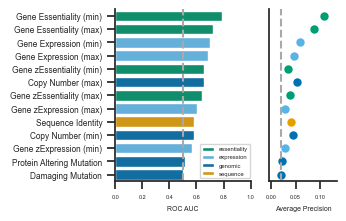

In [11]:
def plot_roc_pr(pred_df):
    sns.set_theme(style="ticks")

    f, ax = plt.subplots(ncols=2, nrows=1, figsize=(3.5, 2.25), sharey=True, gridspec_kw={'width_ratios': [2, 1]})
    
    colors = ["#009E73", "#56B4E9", '#0072B2', "#E69F00"]
    #colors = ["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF"]
    sns.set_palette(sns.color_palette(colors))

    sns.barplot(data=pred_df, x='mean_roc_auc', y='label', hue='category', palette=colors, saturation=0.8, dodge=False, ax=ax[0])
    ax[0].set_xlabel('ROC AUC', size=5) 
    ax[0].set_ylabel('')
    ax[0].set_xlim(0, 1)
    ax[0].tick_params('x', labelsize=4)
    ax[0].tick_params('y', labelsize=6)
    ax[0].axvline(x=0.5, linestyle='--', color='darkgrey')
    ax[0].legend(loc='lower right', fontsize=4.25, bbox_to_anchor=(1.02, 0))
    #ax[0].legend().remove()

    sns.pointplot(data=pred_df, x='avg_precision', y='label', hue='category', palette=colors,
                  dodge=False, markers='o', linestyles='none', errorbar=None, ax=ax[1])
    for line in plt.gca().lines:
        line.set_markersize(4)
    ax[1].set_xlabel('Average Precision', size=5) 
    ax[1].set_ylabel('')
    ax[1].set_xlim(pred_df['avg_precision'].min()-0.025, pred_df['avg_precision'].max()+0.025)
    
    # Remove y-ticks for ax[1]
    ax[1].tick_params('y', left=False, labelleft=False)
    ax[1].tick_params('x', labelsize=4)
    ax[1].axvline(x=no_skill, linestyle='--', color='darkgrey')
    ax[1].legend().remove()

    # Remove top and right borders
    sns.despine(ax=ax[0], top=True, right=True)
    sns.despine(ax=ax[1], top=True, right=True)

    plt.tight_layout(pad=0.7)
    #plt.show()
    plt.savefig(figure_path_b, bbox_inches="tight", dpi=300)

plot_roc_pr(pred_df)

### Box Plot

In [12]:
box_feature = ['rMaxExp_A1A2', 'zMaxExp_A1A2', 'min_ranked_A1A2', 'z_min_ranked_A1A2', 'max_cn', 'max_seq_id']
box_labels = ['Gene Expression (max)', 'Gene zExpression (max)', 'Gene Essentiality (min)', 'Gene zEssentiality (min)', 'Copy Number', 'Sequence Identity']

display(dict(zip(box_feature, box_labels)))

{'rMaxExp_A1A2': 'Gene Expression (max)',
 'zMaxExp_A1A2': 'Gene zExpression (max)',
 'min_ranked_A1A2': 'Gene Essentiality (min)',
 'z_min_ranked_A1A2': 'Gene zEssentiality (min)',
 'max_cn': 'Copy Number',
 'max_seq_id': 'Sequence Identity'}

In [13]:
def draw_signif_line(ax, x0, x1, y, pval, hd=20):
    """Draws a significance line between two box plots."""
    h = y / hd
    if pval < 0.0001: 
        text = '$p$=%.1e' % pval
    else: 
        text = '$p$=%.4f' % pval
    ax.plot([x0, x0, x1, x1], [y + h, y + 2 * h, y + 2 * h, y + h], lw=0.8, c='#666')
    ax.text((x0 + x1) * .5, y + 2.5 * h, text, ha='center', va='bottom', color='#666', fontsize=5)


In [14]:
def compute_upper_whisker(df, feature):
    """Computes the upper whisker of a box plot for a given feature."""
    Q1 = df[feature].quantile(q=0.25)
    Q3 = df[feature].quantile(q=0.75)
    IQR = Q3 - Q1
    return df[df[feature] <= (Q3 + 1.5 * IQR)][feature].max()

In [15]:
def draw_cont_graph(df, feature, target_column, ax, label=None, fliers=True, show_points=True, draw_signif=True, hd=20):
    # Define the color palette based on feature names
    color_mapping = {
        'rMaxExp_A1A2': '#56B4E9',
        'zMaxExp_A1A2': '#56B4E9',
        'min_ranked_A1A2': '#009E73',
        'z_min_ranked_A1A2': '#009E73',
        'max_cn': '#0072B2',
        'max_seq_id': '#E69F00'
    }
    
    # Set the colors for False and True based on the feature
    true_color = color_mapping.get(feature, '#8491B4FF')  # default to original color if feature not in mapping
    my_pal = {False: "white", True: true_color}

    # Calculate the counts of SL and not_SL
    count_SL = (df[target_column] == True).sum()
    count_not_SL = (df[target_column] == False).sum()
    
    sns.despine(top=True, right=True, left=False, bottom=False)
    sns.boxplot(y=feature, x=target_column, hue=target_column, data=df, ax=ax, linewidth=0.8, saturation=0.8, 
                showfliers=False, showmeans=False, palette=my_pal, order=[False, True],  
                medianprops={'color':'black', 'linewidth':0.8},
                boxprops={'edgecolor':'black', 'alpha':0.85},)
    
    ax.set_ylabel(label if label else feature, fontsize=5.75)
    ax.set_xlabel('')
    ax.set_xticks([0, 1])
    ax.set_xticklabels([f'not_SL \n(n={count_not_SL})', f'SL \n(n={count_SL})'])
    ax.tick_params(axis='y', rotation=0, labelsize=4)
    ax.legend().remove()

    #if show_points:
    #    sns.stripplot(y=feature, x=target_column, data=df, color='silver', ax=ax, alpha=0.7, size=2, zorder=0)
    #    ax.set_xlabel('')
    #    ax.legend().remove()

    if draw_signif:
        pval = stats.mannwhitneyu(df.loc[df[target_column] == True, feature], df.loc[df[target_column] == False, feature], alternative="two-sided")[1]
        upper_whisker = max(compute_upper_whisker(df.loc[df[target_column] == True], feature), compute_upper_whisker(df.loc[df[target_column] == False], feature))
        draw_signif_line(ax, 0, 1, upper_whisker + 0.05, pval, hd)


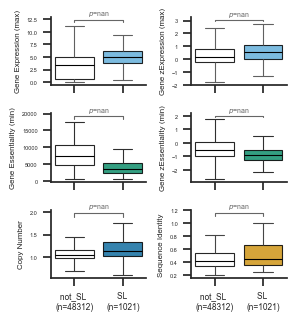

In [16]:
count_SL = (df[target_column] == True).sum()
count_not_SL = (df[target_column] == False).sum()

f, ax = plt.subplots(3, 2, figsize=(3, 3.25), sharex=True)  
ax = ax.flatten()

for i in range(len(box_feature)):
    draw_cont_graph(df, box_feature[i], target_column, ax[i], label=box_labels[i])

# Remove x-tick labels from all subplots except for the second row (indices 2 and 3)
#for i in range(len(ax)):
#    if i != 3 and i != 4:
#        ax[i].set_xticklabels([])

# Set the x-tick labels for the subplot at index 3 (second row, second column)
ax[4].set_xticks([0, 1])
ax[4].set_xticklabels([f'not_SL \n(n={count_not_SL})', f'SL \n(n={count_SL})'], fontsize=6)

ax[5].set_xticks([0, 1])
ax[5].set_xticklabels([f'not_SL \n(n={count_not_SL})', f'SL \n(n={count_SL})'], fontsize=6)

#f.delaxes(ax[-1])
plt.tight_layout(pad=0.7)
f.savefig(figure_path_a, bbox_inches="tight", dpi=300)
#plt.show()